#### Imports

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from matplotlib import style
import seaborn as sns
from sqlalchemy import text, create_engine
import env
import wrangle as w
import explore as e

## Wrangle:
- Acquired data from Codeup MySQL database
    - Initial data frame contains 847,330 rows and 15 columns
- Prepare phase:
    - Dropped columns not needed
        - id, slack, created at, updated at, deleted at
    - Set index to date_time
        - dropped initial date and time columns after they were combined to date_time
    - Updated dtypes for cohort_id (int), start/end dates (datetime64)
    - Dropped rows containing ('/', 'toc', 'search/search_index.json')
        - These rows are landing pages and not lesson pages
    - Dropped rows where program_id == 4 since there were only 4 entries and therefore not a full-fledged program yet.
    - Dropped rows where name == 'Staff', since we are not interested in the frequency of staff visits to the curriculum.
- After prep, data frame has 690,916 rows and 8 columns

In [2]:
# acquire data from csv or MySQL
df = w.get_logs_data()

# prep data frame
df = w.prep_logs(df)

Found CSV


In [3]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
date_time,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


## Exploration

#### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [4]:
#This function splits the file path into main and sub-category, and returns the five top accessed pages per program.

e.most_accessed_per_program(df)

List of most visited for Program 1:

main_path     sub_path    
spring        fundamentals    1426
content       laravel         1188
              html-css         949
javascript-i  introduction     812
html-css      css-i            752
dtype: int64
---------------------
List of most visited for Program 2:

main_path     sub_path    
spring        fundamentals    29505
html-css      css-i           28639
javascript-i  introduction    22420
html-css      css-ii          18635
javascript-i  bom-and-dom     14165
dtype: int64
---------------------
List of most visited for Program 3:

main_path       sub_path                 
classification  overview                     1785
1-fundamentals  modern-data-scientist.jpg    1655
                AI-ML-DL-timeline.jpg        1651
                1.1-intro-to-data-science    1633
classification  scale_features_or_not.svg    1590
dtype: int64
---------------------


Among the **Web Development** cohorts, the most frequently accessed lesson is Spring Fundamentals. 

For the **Data Science** Cohort, the most frequently accessed lesson is Classification: Overview.

#### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [5]:
# Gets number of visits to a particular path per cohort. Calculates Q1, Q3, and the upper fence, and returns a list
# of all cohorts that are above that upper fence with an IQR multiplier of 3.

visits = e.zealous_cohorts(df)

visits

cohort_id  \
main_path      sub_path                                                    
content        laravel                                                13   
               mysql                                                  13   
               javascript_ii                                          13   
               php_iv                                                 13   
               git                                                    13   
...                                                                  ...   
classification classical_programming_vs_machine_learning.jpeg        133   
fundamentals   diagram-of-ds-pipeline-fraud-example.jpeg             137   
               ml-methodologies-drawing.jpg                          137   
               data-science-modules.jpg                              137   
css-i          box-model                                             138   

                                                               num_visits  \
main_path      sub_path                                                     
content        laravel                                                591   
               mysql                                                   83   
               javascript_ii                                           81   
               php_iv                                                 273   
               git                                                    144   
...                                                                   ...   
classification classical_programming_vs_machine_learning.jpeg         432   
fundamentals   diagram-of-ds-pipeline-fraud-example.jpeg               75   
               ml-methodologies-drawing.jpg                            75   
               data-science-modules.jpg                                75   
css-i          box-model                                                2   

                                                                  q1     q3  \
main_path      sub_path                                                       
content        laravel                                          4.00  64.00   
               mysql                                            3.25  21.00   
               javascript_ii                                    6.50  11.75   
               php_iv                                          10.75  31.25   
               git                                              4.75  33.25   
...                                                              ...    ...   
classification classical_programming_vs_machine_learning.jpeg  14.00  60.00   
fundamentals   diagram-of-ds-pipeline-fraud-example.jpeg        8.00  22.00   
               ml-methodologies-drawing.jpg                     8.00  22.00   
               data-science-modules.jpg                         8.00  22.00   
css-i          box-model                                        1.00   1.00   

                                                               upper_fence  
main_path      sub_path                                                     
content        laravel                                              244.00  
               mysql                                                 74.25  
               javascript_ii                                         27.50  
               php_iv                                                92.75  
               git                                                  118.75  
...                                                                    ...  
classification classical_programming_vs_machine_learning.jpeg       198.00  
fundamentals   diagram-of-ds-pipeline-fraud-example.jpeg             64.00  
               ml-methodologies-drawing.jpg                          64.00  
               data-science-modules.jpg                              64.00  
css-i          box-model                                              1.00  

[121 rows x 5 columns]

In [6]:
visits.cohort_id.nunique() # Number of unique cohorts in the previous dataframe.

21

> Not just one cohort, but there are about 21 cohorts that have accessed specific lessons significantly more than other cohorts. We'll get visualizations of what the top three are.

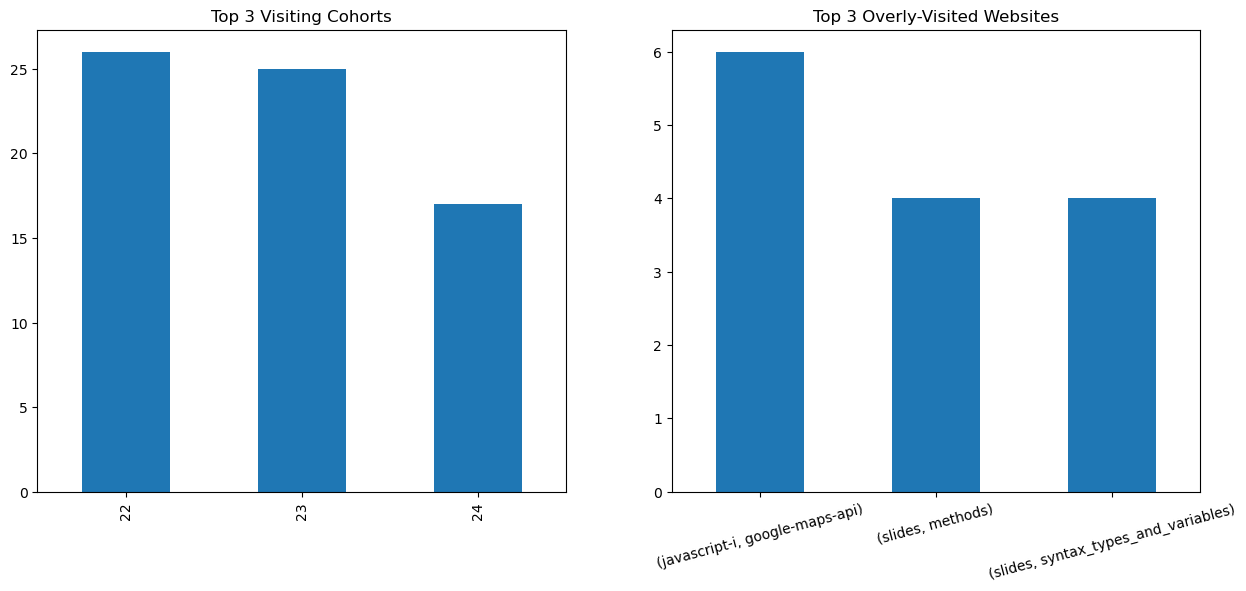

In [7]:
# Get visualizations for top 3 cohorts and top 3 lessons.

e.zealous_cohorts_viz(visits)

> Looking at the visualizations, cohorts **22, 23, and 24** were the cohorts that accessed lessons significantly more than other cohorts.

> Among those lessons, it seems that overall, **Google Maps API, Slides: Methods, and Slides: Syntax Types and Variables** were the three lessons that required the most review/attention.

#### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [8]:
# isolating students who accessed the codeup websites between their start and stop dates
# students who, when active, accessed the curriculum
stud_acc_act = df[(df.index >= df.start_date) & (df.index <= df.end_date)]

In [9]:
# defined low access as less than 100 curriculum visits
# Approximately 100 days of instruction during 5 month course
# these students accessed the curriculum less than 1 per day 
low_access = stud_acc_act.user_id.value_counts() [stud_acc_act.user_id.value_counts() < 101].index

In [10]:
# turned low access students into a data frame
low_access_df = stud_acc_act[stud_acc_act.user_id.isin(low_access)]

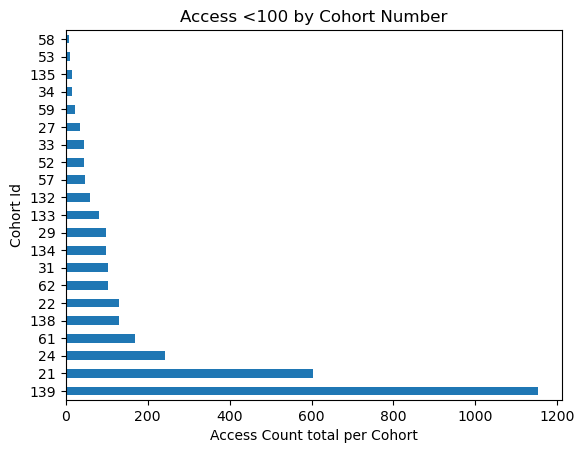

In [11]:
# plotting the total count of curriculum visits per cohort
low_access_df.cohort_id.value_counts().plot.barh()
plt.title('Access <100 by Cohort Number')
plt.ylabel('Cohort Id')
plt.xlabel('Access Count total per Cohort');

- The 2 cohorts who had the most amount of students who accessed the curriculum the least were:
    1. cohort 139 (Oberon) program 2
        - 85% of students are in this category
        - This was a new cohort so this makes sense and is **not** an anomaly
    2. cohort 21 (Sequoia) program 2
        - 39% of students are in this category

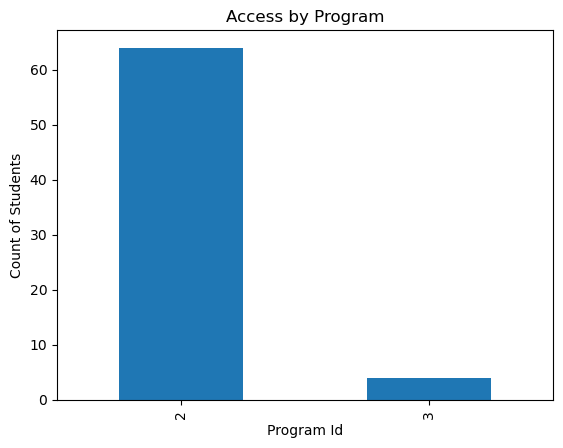

In [12]:
# plotting the count of students 
low_access_df.groupby('program_id').user_id.nunique().plot.bar()
plt.title('Access by Program')
plt.ylabel('Count of Students')
plt.xlabel('Program Id');


- Program 2 (WebDev) had the most students who accessed the curriculum the least

#### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

For this question, we'll run the dataframe through a function that'll give us the answer per program.

In [13]:
# Count of user IDs (i.e. how many times this path was accessed) for Program 1 after they graduated.

e.lessons_after_grad(df, 1)

user_id
main_path sub_path             
spring    fundamentals     1426
content   laravel          1188
          html-css          949

In [14]:
# Same, but for program 2.

e.lessons_after_grad(df, 2)

,,user_id
main_path,sub_path,
spring,fundamentals,5400
html-css,css-i,1986
javascript-i,introduction,1489


In [15]:
# Same, but for program 3.

e.lessons_after_grad(df, 3)

user_id
main_path      sub_path                          
sql            mysql-overview                 275
classification overview                       267
               scale_features_or_not.svg      220

All in all, much like the first question, the top most re-visited topics after graduation for **Web Development** cohorts are **Spring Fundamentals, HTML CSS, Javascript, and Laravel**.

For **Data Science** cohorts, this answer differs from the first question's answer. Their more re-visited topics are **MySQL: Overview, Classification, and Scaling**.

#### 7. Which lessons are least accessed?

In [16]:
# this function isolates webdev students and iterates over the lesson name to get lesson count
e.least_accessed_web_dev(df)

Lessons accessed the least:
capstone: 1385
design: 1648
mkdocs: 1865
slides: 7130
content: 8679


For WebDev, the following are the least accessed lessons:
- Slides
- Capstone
- MkDocs

In [17]:
# this function isolates DS students and iterates over the lesson name to get lesson count
e.least_accessed_ds(df)

Lessons accessed the least:
topics: 1278
ml: 1655
nlp: 3207
storytelling: 3296
timeseries: 3313


For DS, the follwing are the least accessed lessons:
- Machine learning
- Natural Language Processing (NLP)
- Storytelling

#### 8. Anything else I should be aware of?

Yes.

- During the Acquisition phase, we found an instance claiming that Student ID 643 had been based. 
- Staff is included under Program ID 2, which doesn't make sense. They should be under a separate program.
- Bayes does not have a slack name, which should be fixed.
- A lot of answers required sifting through junk data, as a lot of "anomalies" came from webpages that had been misspelled and were otherwise relics of first drafts of that particular page/lesson.

# Conclusion

- Overall, Web Dev students hit the curriculum more often, and even had access to Data Science material. 
- Data Science cohorts, on the other hand, did not have access to Web Dev material.
- Web Dev students accessed the same material both during their cohort and after their graduation.
- Data Science students reviewed MySQL moreso after graduation than during their time at Codeup.
- At least speaking for Data Science students, the least accessed materials are those that are covered towards the end of the curriculum.